### Data

In [13]:
import itertools
import numpy as np

from load_data import CodeNamesData

In [3]:
data = CodeNamesData('words_categories.txt')

In [4]:
sample_field = data.sample_field()

In [5]:
import fasttext
ft = fasttext.load_model('cc.en.300.bin')

word_vectors = {word: ft.get_word_vector(word) for word in data.vocabulary}

In [6]:
def get_training_examples(field):
    examples = []
    blue_cat = set(field['blue'])
    for cat in field['blue']:
        example = {}
        example['chosen_blue'] = field['blue'][cat]
        example['other_blue'] = list(itertools.chain(*[field['blue'][c] for c in (blue_cat - set([cat]))]))
        example['neutral'] = field['neutral']
        example['black'] = field['black']
        examples.append((example, cat))
    return examples

In [8]:
def embed_examples(examples, word2embedding, pad_chosen=True):
    result = []
    for example, label in examples:
        embed_example = {'blue': []}
        for w in example['chosen_blue']:
            if pad_chosen:
                embed_example['blue'].append(np.concatenate([np.ones(1).astype(np.float32), word2embedding[w]]))
            else:
                embed_example['blue'].append(word2embedding[w])
                
        for w in example['other_blue']:
            if pad_chosen:
                embed_example['blue'].append(np.concatenate([np.zeros(1).astype(np.float32), word2embedding[w]]))
            else:
                embed_example['blue'].append(word2embedding[w])
        embed_example['blue'] = np.array(embed_example['blue'])
        embed_example['neutral'] = np.array([word2embedding[w] for w in example['neutral']])
        embed_example['black'] = word2embedding[example['black']]
        result.append((embed_example, label))
    return result

In [9]:
category2idx = {category: i for i, category in enumerate(data.categories)}
idx2category = {v: k for k, v in category2idx.items()}

In [130]:
from copy import deepcopy

def get_examples_for_bob(examples):
    bob_examples = []
    field = []
    for color in examples[0][0]:
        if color == 'black':
            field.append(examples[0][0][color])
        else:
            field.extend(examples[0][0][color])
    
    for field_info, _ in examples:
        np.random.shuffle(field)
        answers = []
        for a in field_info['chosen_blue']:
            answers.append(field.index(a))
        bob_examples.append((deepcopy(field), answers))
    return bob_examples

In [131]:
def get_batch(n_fields, word2embedding, pad_chosen=True):
    get_batch.fields = []
    colored_fields_examples = {'blue': [], 'neutral': [], 'black': [], 'label': []}
    fields_examples = {'field': [], 'label': []}
    fields_embs = []
    for i in range(n_fields):
        field = data.sample_field()
        examples = get_training_examples(field)
        bob_examples = get_examples_for_bob(examples)
        for bob_example, answers in bob_examples:
            fields_examples['field'].append([word2embedding[w] for w in bob_example])
            fields_examples['label'].append(answers)
        
        fields_embs.extend(embed_examples(examples, word2embedding, pad_chosen))
        get_batch.fields.append(field)
    
    
    for field, label in fields_embs:
        np.random.shuffle(field['blue'])
        np.random.shuffle(field['neutral'])
        colored_fields_examples['blue'].append(field['blue'])
        colored_fields_examples['neutral'].append(field['neutral'])
        colored_fields_examples['black'].append(field['black'])
        colored_fields_examples['label'].append(category2idx[label])
    colored_fields_examples['blue'] = np.array(colored_fields_examples['blue'])
    colored_fields_examples['neutral'] = np.array(colored_fields_examples['neutral'])
    colored_fields_examples['black'] = np.array(colored_fields_examples['black'])
    
    fields_examples['field'] = np.array(fields_examples['field'])
    return colored_fields_examples, fields_examples

### Network

In [142]:
import torch
import torch.nn.functional as F
from torch import nn, optim

In [137]:
class AliceNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, n_hints, pad_chosen=True):
        super().__init__()
        if pad_chosen:
            self.emb_blue = nn.LSTM(input_size + 1, hidden_size, n_layers)
        else:
            self.emb_blue = nn.LSTM(input_size, hidden_size, n_layers)
        self.emb_neutral = nn.LSTM(input_size, hidden_size, n_layers)
        self.emb_black = nn.Linear(input_size, hidden_size)
        self.hint_producer = nn.Sequential(nn.Linear(hidden_size * 3, 256),
                                           nn.ReLU(),
                                           nn.Linear(256, 128),
                                           nn.ReLU(),
                                           nn.Linear(128, n_hints))
    
    def forward(self, blue_words, neutral_words, black_words):
        blue_embs, _ = self.emb_blue(blue_words)
        neutral_embs, _ = self.emb_neutral(neutral_words)
        black_embs = F.relu(self.emb_black(black_words))
        
        out = torch.cat([blue_embs[-1], neutral_embs[-1], black_embs], dim=1)
        out = self.hint_producer(out)
        return out

In [138]:
class BobNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, field_size):
        super().__init__()
        self.emb_field = nn.LSTM(input_size, hidden_size, n_layers)
        self.emb_hint = nn.Linear(input_size, hidden_size)
        
        
        self.classifier = nn.Sequential(nn.Linear(hidden_size * 2, 256),
                                        nn.ReLU(),
                                        nn.Linear(256, 128),
                                        nn.ReLU(),
                                        nn.Linear(128, field_size))
    
    def forward(self, field, hint):
        field_emb, _ = self.emb_field(field)
        hint_emb = self.emb_hint(hint)
        
        out = torch.cat([field_emb[-1], hint_emb], dim=1)
        out = self.classifier(out)
        return out

In [266]:
alice_b, bob_b = get_batch(8, word_vectors)

In [267]:
alice_net = AliceNetwork(300, 256, 2, 25)
bob_net = BobNetwork(300, 256, 2, 25)

In [268]:
blue_t = torch.as_tensor(alice_b['blue'], dtype=torch.float32)
neutral_t = torch.as_tensor(alice_b['neutral'], dtype=torch.float32)
black_t = torch.as_tensor(alice_b['black'], dtype=torch.float32)

In [269]:
out = alice_net(blue_t.permute(1, 0, 2), neutral_t.permute(1, 0, 2), black_t)

In [170]:
field_t = torch.as_tensor(bob_b['field'], dtype=torch.float32)

hint = np.random.choice(data.categories, size=field_t.shape[0])
hint_t = torch.as_tensor([ft.get_word_vector(h) for h in hint], dtype=torch.float32)

In [171]:
bob_out = bob_net(field_t.permute(1, 0, 2), hint_t)

In [189]:
out.topk(1)[1].squeeze()

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6])

In [227]:
def sample_action(qvalues_tensor, epsilon, n_actions=25):
    actions = qvalues_tensor.topk(1)[1].squeeze()
    for i in range(len(actions)):
        if epsilon < np.random.random():
            actions[i] = np.random.choice(n_actions)
    return actions.detach()

In [229]:
act = sample_action(out, 0.5)

In [232]:
labels_t = torch.as_tensor(alice_b['label'], dtype=torch.float32)

In [240]:
(labels_t == act).type(torch.uint8)

tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0], dtype=torch.uint8)

tensor([ 6, 21,  6,  3,  6, 19, 23, 16,  6,  5,  6,  6,  1,  6,  5,  5, 21,  6,
         4, 15,  6,  6, 11,  6,  6,  7, 18,  6])

In [231]:
.shape

torch.Size([28])

### Training functions

In [174]:
import typing as tp
from typing_extensions import Protocol

class Visitor(Protocol):
    def log(self, prediction: tp.Any, target: tp.Any) -> None:
        pass

In [323]:
from IPython import display
import time

import matplotlib.pyplot as plt
import seaborn as sns

def compute_accuracy(logits, labels):
    """
    Computes accuracy
    logits (torch.tensor [batch_size, number or labels]): usually the output of the network
    labels (torch.tensor): true labels
    """
    acc = np.mean(labels.cpu().numpy() == logits.topk(1, dim=1)
                  [1].cpu().data.numpy().reshape(-1))
    return acc

def train_epoch(
    alice_field: tp.Any,
    bob_field: tp.Any,
    model: torch.nn.Module,
    compute_loss: tp.Callable[[torch.tensor, torch.tensor], torch.tensor],
    optimizer: torch.optim,
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu'),) -> tp.List[float]:
    """
   Performs one training loop
   :param model: model to train
   :param compute_loss: function for loss computation, predictions should be passed as logits
   :param optimizer: optimizer
   :param visitor: visitor with method 'log' which have two required parameters 'prediction' and 'target'
   :param device: whether to train on gpu or cpu
   :return: epoch loss log and IoU
   """

    loss_log, accuracy_log = [], []

    model.train()
    blue_tensor = torch.as_tensor(alice_field['blue'], dtype=torch.float32, device=device).permute(1, 0, 2)
    neutral_tensor = torch.as_tensor(alice_field['neutral'], dtype=torch.float32, device=device).permute(1, 0, 2)
    black_tensor = torch.as_tensor(alice_field['black'], dtype=torch.float32, device=device)
    labels = torch.as_tensor(alice_field['label'], dtype=torch.long, device=device)

    optimizer.zero_grad()

    logits = model(blue_tensor, neutral_tensor, black_tensor)
    loss = compute_loss(logits, labels)
    loss.backward()
    optimizer.step()

    loss_log.append(loss.item())
    accuracy_log.append(compute_accuracy(logits, labels))

    return loss_log, accuracy_log


def sample_action(qvalues_tensor, epsilon, n_actions=25):
    actions = qvalues_tensor.topk(1)[1].squeeze()
    for i in range(len(actions)):
        if epsilon < np.random.random():
            actions[i] = np.random.choice(n_actions)
    return actions.detach()

def train_epoch_qlearning(
        alice_field: tp.Any,
        bob_field: tp.Any,
        model: torch.nn.Module,
        optimizer: torch.optim,
        epsilon: float,
        device: torch.device = torch.device(
            'cuda:0' if torch.cuda.is_available() else 'cpu')) -> tp.List[float]:
    """
   Performs one training loop
   :param model: model to train
   :param compute_loss: function for loss computation, predictions should be passed as logits
   :param optimizer: optimizer
   :param visitor: visitor with method 'log' which have two required parameters 'prediction' and 'target'
   :param device: whether to train on gpu or cpu
   :return: epoch loss log and IoU
   """

    loss_log, accuracy_log = [], []

    model.train()
    blue_tensor = torch.as_tensor(alice_field['blue'], dtype=torch.float32, device=device).permute(1, 0, 2)
    neutral_tensor = torch.as_tensor(alice_field['neutral'], dtype=torch.float32, device=device).permute(1, 0, 2)
    black_tensor = torch.as_tensor(alice_field['black'], dtype=torch.float32, device=device)
    labels = torch.as_tensor(alice_field['label'], dtype=torch.long, device=device)

    optimizer.zero_grad()

    qvalues = model(blue_tensor, neutral_tensor, black_tensor)
    actions = sample_action(qvalues, epsilon)
    qvalues_for_actions = qvalues[range(qvalues.shape[0]), actions]
    rewards = (labels == actions).type(torch.float32)
    rewards = (rewards - 1) + (10 * rewards)
    # print(rewards)
    # print((qvalues_for_actions.squeeze() - rewards.detach().squeeze()) ** 2)
    loss = torch.sum((qvalues_for_actions.squeeze() - rewards.detach().squeeze()) ** 2)
    
    loss.backward()
    optimizer.step()

    loss_log.append(loss.item())
    accuracy_log.append(compute_accuracy(qvalues, labels))

    return loss_log, accuracy_log

def visualize(train_loss_log, train_accuracy_log):
    sns.set()
    plt.rcParams["figure.figsize"] = (15, 5)

    fig, axs = plt.subplots(1, 2)
    axs[0].plot(train_loss_log, label='train')
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('loss')
    axs[0].legend()

    axs[1].plot(train_accuracy_log, label='train')
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()
    plt.show()
    
def ignore_keyboard_traceback(func):
    def wrapper(*args, **kwargs):
        try:
            func(*args, **kwargs)
        except KeyboardInterrupt:
            pass

    return wrapper

def get_epsilon(epoch):
    epsilon = 0.95
    decay = 0.9995
    min_epsilon = 0.01
    return epsilon * (decay ** epoch)

@ignore_keyboard_traceback
def train(
    n_epochs,
    n_fields,
    model,
    criterion,
    optimizer,
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    pad_chosen=True):

    model.to(device)

    train_loss_log, train_accuracy_log = [], []

    for epoch in range(n_epochs):

        start = time.time()
        alice_field, bob_field = get_batch(n_fields, word_vectors, pad_chosen)
        
        train_epoch_loss, train_epoch_accuracy = train_epoch_qlearning(alice_field,
                                                                       bob_field,
                                                                       model,
                                                                       optimizer,
                                                                       get_epsilon(epoch),
                                                                       device)
        if epoch % 50 == 0:
            train_loss_log.append(np.mean(train_epoch_loss))
            train_accuracy_log.append(np.mean(train_epoch_accuracy))

        end = time.time()

        if epoch % 50 == 0:
            display.clear_output()
            print(f'Epoch #{epoch + 1}')
            print('---------------')
            print(f'Epoch time:  {int((end - start) % 60)} sec')
            print()
            print(
                f'Train loss: {train_loss_log[-1]:.3f}  |  Train accuracy: {100*train_accuracy_log[-1]:.3f}%'
            )
            print()

            visualize(train_loss_log, train_accuracy_log)

In [324]:
input_size = 300
hidden_size=256
n_layers = 2
n_hints = 25
pad_chosen=True

model = AliceNetwork(input_size, hidden_size, n_layers, n_hints, pad_chosen=pad_chosen)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

Epoch #9951
---------------
Epoch time:  0 sec

Train loss: 112.679  |  Train accuracy: 33.333%



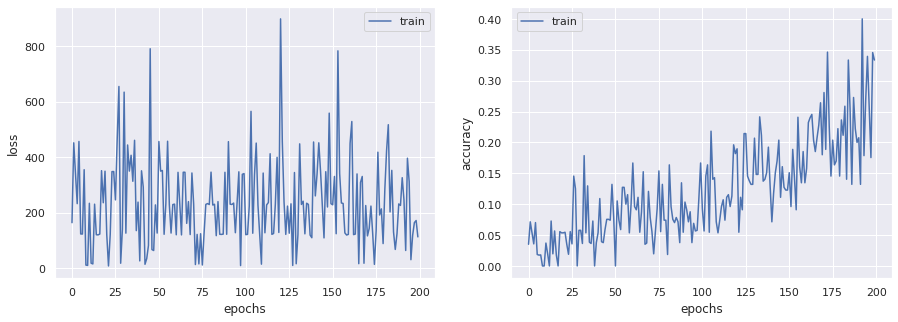

In [325]:
# reward -1 or 10
n_epochs = 10000
n_fields = 16

train(n_epochs, n_fields, model, criterion, optimizer, pad_chosen=pad_chosen)

Epoch #6901
---------------
Epoch time:  0 sec

Train loss: 0.190  |  Train accuracy: 98.182%



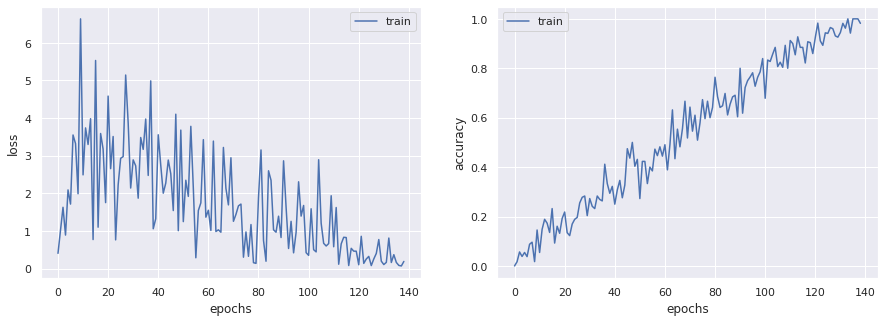

In [314]:
# reward 0 or 1
n_epochs = 10000
n_fields = 16

train(n_epochs, n_fields, model, criterion, optimizer, pad_chosen=pad_chosen)

In [315]:
b, _ = get_batch(8, word_vectors, pad_chosen)
device = torch.device('cuda')
blue_t = torch.as_tensor(b['blue'], dtype=torch.float32, device=device)
neutral_t = torch.as_tensor(b['neutral'], dtype=torch.float32, device=device)
black_t = torch.as_tensor(b['black'], dtype=torch.float32, device=device)
labels = torch.as_tensor(b['label'], dtype=torch.long, device=device)

In [319]:
blue_t[:, :, 0] = 0.

In [320]:
out = model(blue_t.permute(1, 0, 2), neutral_t.permute(1, 0, 2), black_t)

In [321]:
labels

tensor([24,  4, 19,  7,  9, 16,  5, 10, 20,  8,  7, 15, 23,  5, 18, 22,  9,  5,
        23, 22, 17, 19, 23, 16, 11, 14, 11, 24], device='cuda:0')

In [322]:
out.topk(1)[1].squeeze()

tensor([ 3,  3,  1, 16,  1,  1,  9, 20, 20, 10,  1,  1,  1,  1,  3,  9,  2,  1,
        21, 22,  3, 19, 20,  1,  1,  1,  3, 16], device='cuda:0')

In [182]:
input_size = 300
hidden_size=256
n_layers = 2
n_hints = 25
pad_chosen=False

model = AliceNetwork(input_size, hidden_size, n_layers, n_hints, pad_chosen=pad_chosen)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

Epoch #2951
---------------
Epoch time:  0 sec

Train loss: 1.728  |  Train accuracy: 26.923%



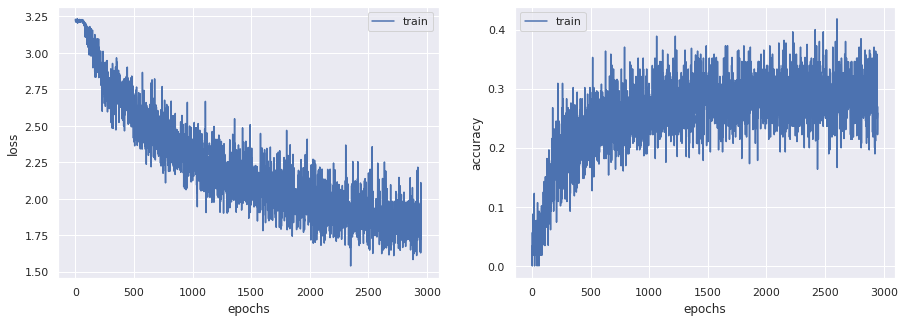

In [183]:
# pad_chosen = False
n_epochs = 3000
n_fields = 16

train(n_epochs, n_fields, model, criterion, optimizer, pad_chosen=pad_chosen)

Epoch #1451
---------------
Epoch time:  0 sec

Train loss: 0.190  |  Train accuracy: 92.857%



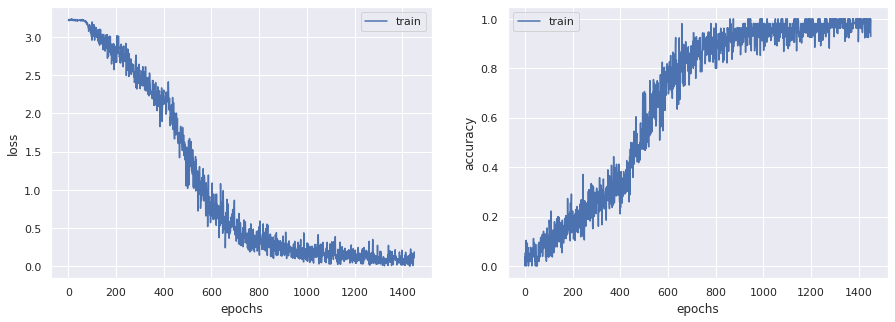

In [655]:
# pad_chosen = True
n_epochs = 1500
n_fields = 16

train(n_epochs, n_fields, model, criterion, optimizer)